In [18]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn

import argparse
import time
import pandas as pd

from easydict import EasyDict as edict
from tqdm import trange
from torchsummary import summary
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns

YOUR_PATH = "/home/jyt/workspace/fNIRS_models/code_data_tufts"
sys.path.insert(0, YOUR_PATH + '/fNIRS-mental-workload-classifiers/helpers')
import models
import brain_data
from utils import generic_GetTrainValTestSubjects, seed_everything, makedir_if_not_exist, plot_confusion_matrix, save_pickle, train_one_epoch, eval_model, save_training_curves_FixedTrainValSplit, write_performance_info_FixedTrainValSplit, write_program_time, write_inference_time
from utils import LabelSmoothing, train_one_epoch_fNIRS_T, eval_model_fNIRST, train_one_epoch_Ours_T, eval_model_OursT
from utils import EarlyStopping


paint the results of Ablation experiments

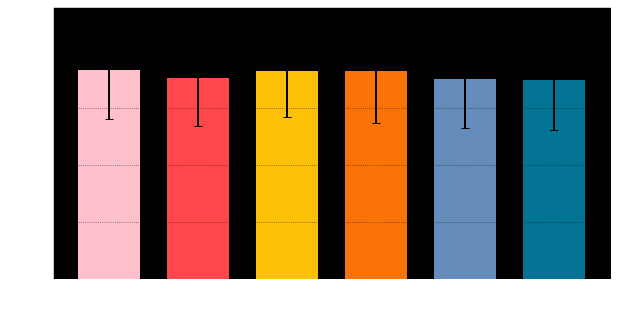

In [8]:
%matplotlib inline
x=[1,2,3,4,5,6]
y = [73.21, 70.52, 73.07, 72.86, 70.06, 69.88]
std_err = [17.24, 16.87, 16.18, 18.05, 17.05, 17.77]

error_params = dict(elinewidth=2,ecolor='black',capsize=4)

plt.figure(figsize=(10, 5))
plt.bar(x,y,color=['pink','xkcd:light red','xkcd:marigold','xkcd:orange','xkcd:faded blue','xkcd:sea blue'],yerr=std_err,error_kw=error_params,\
                    tick_label=['Ours','Ours+CNN','Ours\n+MixUp','Ours\n+MixUp\n+Real',\
                        'Ours+CNN\n+MixUp','Ours+CNN\n+MixUp\n+Real'], width=0.7)
plt.grid(True,axis='y',ls=':',color='black',alpha=0.6)
plt.ylabel("Average \n accuracy(%)")
plt.rcParams['pdf.fonttype'] = 42
#plt.show()
plt.savefig('mixup_pdf_4.pdf', bbox_inches='tight')

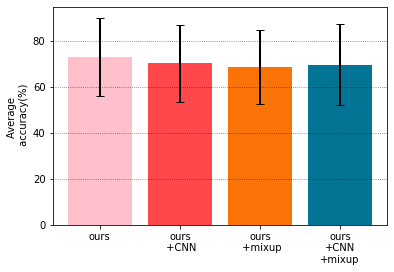

In [15]:
%matplotlib inline
x=[1,2,3,4]
y = [73.21, 70.52, 68.76, 69.88]
std_err = [17.24, 16.87, 16.25, 17.77]

error_params = dict(elinewidth=2,ecolor='black',capsize=4)

plt.bar(x,y,color=['pink','xkcd:light red','xkcd:orange','xkcd:sea blue'],yerr=std_err,error_kw=error_params,\
                    tick_label=['ours','ours\n +CNN','ours\n +mixup','ours\n+CNN\n+mixup'])
plt.grid(True,axis='y',ls=':',color='black',alpha=0.6)
plt.ylabel("Average \n accuracy(%)")
plt.rcParams['pdf.fonttype'] = 42
#plt.show()
plt.savefig('mixup_pdf.pdf', bbox_inches='tight')

In [ ]:
x=[1,2,3,4]
y = [73.21, 70.52, 68.76, 69.88]
std_err = [17.24, 16.87, 16.25, 17.77]

error_params = dict(elinewidth=2,ecolor='black',capsize=4)

plt.bar(x,y,color=['pink','xkcd:light red','xkcd:lemon','xkcd:sea blue'],yerr=std_err,error_kw=error_params,\
                    tick_label=['ours','ours\n +CNN','ours\n +mixup','ours\n+CNN\n+mixup'])
plt.grid(True,axis='y',ls=':',color='black',alpha=0.6)
plt.ylabel("average \n accuracy(%)")
#plt.show()
plt.savefig('result.svg', bbox_inches='tight')

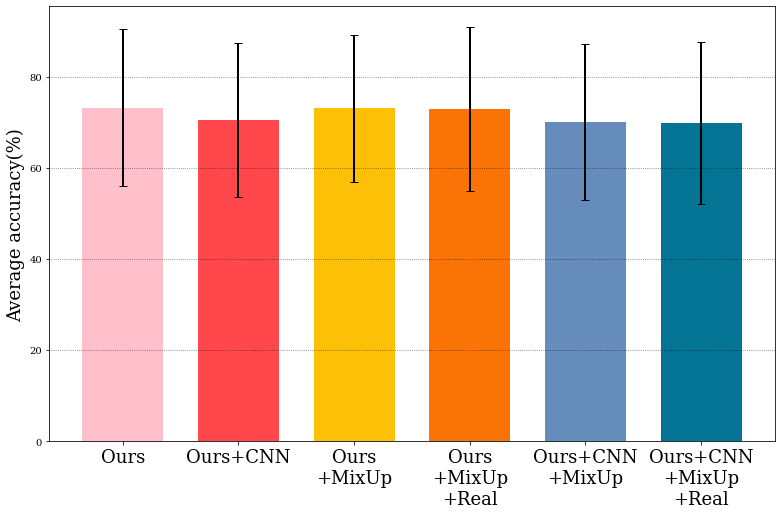

In [34]:
%matplotlib inline
x=[1,2,3,4,5,6]
y = [73.21, 70.52, 73.07, 72.86, 70.06, 69.88]
std_err = [17.24, 16.87, 16.18, 18.05, 17.05, 17.77]

error_params = dict(elinewidth=2,ecolor='black',capsize=4)

plt.figure(figsize=(13, 8))
#plt.style.use('default')
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.bar(x,y,color=['pink','xkcd:light red','xkcd:marigold','xkcd:orange','xkcd:faded blue','xkcd:sea blue'],yerr=std_err,error_kw=error_params,\
                    width=0.7)
plt.xticks(x, ['Ours','Ours+CNN','Ours\n+MixUp','Ours\n+MixUp\n+Real',\
                        'Ours+CNN\n+MixUp','Ours+CNN\n+MixUp\n+Real'], fontsize=18)
plt.grid(True,axis='y',ls=':',color='black',alpha=0.6)
plt.ylabel("Average accuracy(%)", fontsize=18)
plt.rcParams['pdf.fonttype'] = 42  # modify the image type for paper submission
#plt.show()
plt.savefig('mixup_pdf_5.pdf', bbox_inches='tight')

In [21]:
set([f.name for f in matplotlib.font_manager.fontManager.afmlist])

{'Bitstream Charter',
 'Century Schoolbook L',
 'Computer Modern',
 'Courier',
 'Courier 10 Pitch',
 'Dingbats',
 'Helvetica',
 'ITC Avant Garde Gothic',
 'ITC Bookman',
 'ITC Zapf Chancery',
 'ITC Zapf Dingbats',
 'New Century Schoolbook',
 'Nimbus Mono L',
 'Nimbus Roman No9 L',
 'Nimbus Sans L',
 'Palatino',
 'Standard Symbols L',
 'Symbol',
 'Times',
 'URW Bookman L',
 'URW Chancery L',
 'URW Gothic L',
 'URW Palladio L',
 'Utopia',
 'ZapfDingbats'}